# AlexNet
- ReLU
- Local Response Normalization
- Overlapping Pooling
- Dropout

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import os
import sys
import argparse
import time
from tqdm import tqdm
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Load

In [38]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((227, 227)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

])

transform_test = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


논문에서 언급된 Data Augmentation 방식대로 이미지 전처리
- 직접 augmentation을 수행하진 않지만, 이와 유사한 방식으로 전처리 수행
- (256 x 256) 크기의 이미지에 대해 (227 x 227) 크기의 patch 추출(`centerCrop`)
- 절반의 확률로 horizontal reflection

# Model

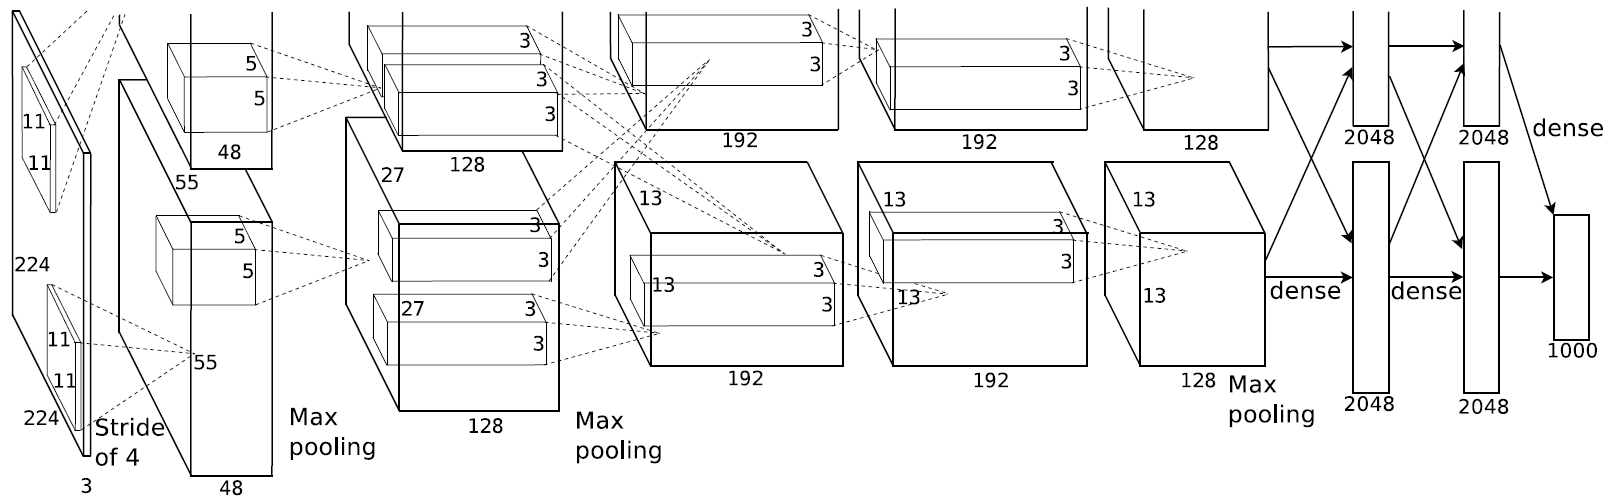

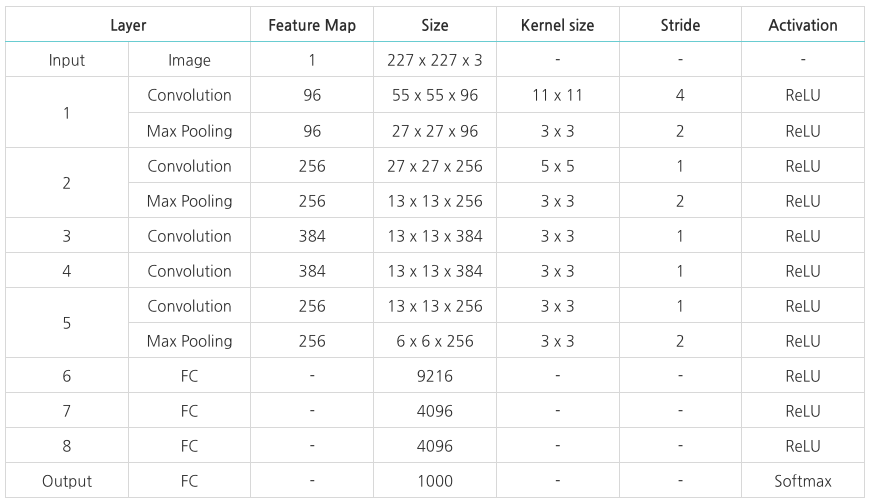

In [3]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11, 11), stride=4, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=10),
        )

    def init_bias(self):
        for layer in self.layers:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01), # weight 초기화
                nn.init.constant_(layer.bias, 0) # bias 초기화

            # layer 2,4,5의 bias는 1로 초기화
            nn.init.constant_(self.layers[4].bias, 1),
            nn.init.constant_(self.layers[10].bias, 1),
            nn.init.constant_(self.layers[12].bias, 1),

    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 256*6*6)
        x = self.classifier(x)
        return x

- CIFAR10 dataset을 사용하므로 output의 차원은 10으로 조정
- `LocalResponseNorm` 적용
- weight와 bias 초기화

In [7]:
import torchsummary

model = AlexNet()
model.to(device)

torchsummary.summary(model, input_size=(3, 227, 227), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

# Train & Test

In [49]:
# model parameters
NUM_EPOCHS = 50
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR = 0.0001
MODEL_NAME='AlexNet'

best_acc = 0
start_epoch = 0

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr = LR,
                      momentum = MOMENTUM,
                      weight_decay = LR_DECAY)

In [42]:
def model_train(model, data_loader, criterion, optimizer, device):
    model.train()

    running_size = 0
    running_loss = 0
    corr = 0

    prograss_bar = tqdm(data_loader)

    for batch_idx, (img, lbl) in enumerate(prograss_bar, start=1):
        img, lbl = img.to(device), lbl.to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, lbl)

        loss.backward()
        optimizer.step()

        _, pred = output.max(dim=1)
        corr += pred.eq(lbl).sum().item()
        running_loss += loss.item() * img.size(0)
        running_size += img.size(0)
        prograss_bar.set_description(f'[Training] loss: {running_loss / running_size:.4f}, accuracy: {corr / running_size:.4f}')

    acc = corr / len(data_loader.dataset)

    return running_loss / len(data_loader.dataset), acc

In [47]:
def model_evaluate(model, data_loader, criterion, device):
    model.eval()

    with torch.no_grad():
        corr = 0
        running_loss = 0

        for img, lbl in data_loader:
            img, lbl = img.to(device), lbl.to(device)

            output = model(img)

            _, pred = output.max(dim=1)
            corr += torch.sum(pred.eq(lbl)).item()

            running_loss += criterion(output, lbl).item() * img.size(0)

        acc = corr / len(data_loader.dataset)

        return running_loss / len(data_loader.dataset), acc

In [50]:
min_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = model_evaluate(model, test_loader, criterion, device)

    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{MODEL_NAME}.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

[Training] loss: 2.3026, accuracy: 0.0999: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


[INFO] val_loss has been improved from inf to 2.30252. Saving Model!
epoch 01, loss: 2.30257, acc: 0.09992, val_loss: 2.30252, val_accuracy: 0.10000


[Training] loss: 2.3025, accuracy: 0.0996: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


[INFO] val_loss has been improved from 2.30252 to 2.30249. Saving Model!
epoch 02, loss: 2.30255, acc: 0.09960, val_loss: 2.30249, val_accuracy: 0.10000


[Training] loss: 2.3025, accuracy: 0.0996: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


[INFO] val_loss has been improved from 2.30249 to 2.30246. Saving Model!
epoch 03, loss: 2.30252, acc: 0.09960, val_loss: 2.30246, val_accuracy: 0.10000


[Training] loss: 2.3025, accuracy: 0.1001: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


[INFO] val_loss has been improved from 2.30246 to 2.30243. Saving Model!
epoch 04, loss: 2.30250, acc: 0.10012, val_loss: 2.30243, val_accuracy: 0.10000


[Training] loss: 2.3025, accuracy: 0.0993: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.30243 to 2.30240. Saving Model!
epoch 05, loss: 2.30248, acc: 0.09926, val_loss: 2.30240, val_accuracy: 0.10000


[Training] loss: 2.3025, accuracy: 0.0994: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s]


[INFO] val_loss has been improved from 2.30240 to 2.30237. Saving Model!
epoch 06, loss: 2.30245, acc: 0.09942, val_loss: 2.30237, val_accuracy: 0.10000


[Training] loss: 2.3024, accuracy: 0.1000: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


[INFO] val_loss has been improved from 2.30237 to 2.30234. Saving Model!
epoch 07, loss: 2.30243, acc: 0.09998, val_loss: 2.30234, val_accuracy: 0.10000


[Training] loss: 2.3024, accuracy: 0.0992: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


[INFO] val_loss has been improved from 2.30234 to 2.30230. Saving Model!
epoch 08, loss: 2.30240, acc: 0.09918, val_loss: 2.30230, val_accuracy: 0.10000


[Training] loss: 2.3024, accuracy: 0.0995: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


[INFO] val_loss has been improved from 2.30230 to 2.30227. Saving Model!
epoch 09, loss: 2.30238, acc: 0.09952, val_loss: 2.30227, val_accuracy: 0.10000


[Training] loss: 2.3023, accuracy: 0.0992: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


[INFO] val_loss has been improved from 2.30227 to 2.30224. Saving Model!
epoch 10, loss: 2.30234, acc: 0.09916, val_loss: 2.30224, val_accuracy: 0.10000


[Training] loss: 2.3023, accuracy: 0.1001: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


[INFO] val_loss has been improved from 2.30224 to 2.30220. Saving Model!
epoch 11, loss: 2.30234, acc: 0.10014, val_loss: 2.30220, val_accuracy: 0.10000


[Training] loss: 2.3023, accuracy: 0.0997: 100%|██████████| 391/391 [02:04<00:00,  3.15it/s]


[INFO] val_loss has been improved from 2.30220 to 2.30216. Saving Model!
epoch 12, loss: 2.30229, acc: 0.09974, val_loss: 2.30216, val_accuracy: 0.10000


[Training] loss: 2.3023, accuracy: 0.1007: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


[INFO] val_loss has been improved from 2.30216 to 2.30212. Saving Model!
epoch 13, loss: 2.30226, acc: 0.10070, val_loss: 2.30212, val_accuracy: 0.10000


[Training] loss: 2.3022, accuracy: 0.1014: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


[INFO] val_loss has been improved from 2.30212 to 2.30208. Saving Model!
epoch 14, loss: 2.30224, acc: 0.10142, val_loss: 2.30208, val_accuracy: 0.10000


[Training] loss: 2.3022, accuracy: 0.1017: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.30208 to 2.30203. Saving Model!
epoch 15, loss: 2.30220, acc: 0.10170, val_loss: 2.30203, val_accuracy: 0.10000


[Training] loss: 2.3022, accuracy: 0.1024: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


[INFO] val_loss has been improved from 2.30203 to 2.30199. Saving Model!
epoch 16, loss: 2.30217, acc: 0.10242, val_loss: 2.30199, val_accuracy: 0.10000


[Training] loss: 2.3022, accuracy: 0.1031: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


[INFO] val_loss has been improved from 2.30199 to 2.30193. Saving Model!
epoch 17, loss: 2.30215, acc: 0.10308, val_loss: 2.30193, val_accuracy: 0.10000


[Training] loss: 2.3021, accuracy: 0.1053: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


[INFO] val_loss has been improved from 2.30193 to 2.30188. Saving Model!
epoch 18, loss: 2.30208, acc: 0.10534, val_loss: 2.30188, val_accuracy: 0.10020


[Training] loss: 2.3021, accuracy: 0.1078: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


[INFO] val_loss has been improved from 2.30188 to 2.30182. Saving Model!
epoch 19, loss: 2.30206, acc: 0.10780, val_loss: 2.30182, val_accuracy: 0.10060


[Training] loss: 2.3020, accuracy: 0.1083: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


[INFO] val_loss has been improved from 2.30182 to 2.30176. Saving Model!
epoch 20, loss: 2.30202, acc: 0.10832, val_loss: 2.30176, val_accuracy: 0.10850


[Training] loss: 2.3020, accuracy: 0.1109: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.30176 to 2.30169. Saving Model!
epoch 21, loss: 2.30196, acc: 0.11090, val_loss: 2.30169, val_accuracy: 0.11950


[Training] loss: 2.3019, accuracy: 0.1214: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


[INFO] val_loss has been improved from 2.30169 to 2.30161. Saving Model!
epoch 22, loss: 2.30191, acc: 0.12142, val_loss: 2.30161, val_accuracy: 0.13450


[Training] loss: 2.3019, accuracy: 0.1224: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


[INFO] val_loss has been improved from 2.30161 to 2.30153. Saving Model!
epoch 23, loss: 2.30187, acc: 0.12236, val_loss: 2.30153, val_accuracy: 0.14640


[Training] loss: 2.3018, accuracy: 0.1273: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.30153 to 2.30144. Saving Model!
epoch 24, loss: 2.30178, acc: 0.12728, val_loss: 2.30144, val_accuracy: 0.16090


[Training] loss: 2.3017, accuracy: 0.1351: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.30144 to 2.30134. Saving Model!
epoch 25, loss: 2.30172, acc: 0.13510, val_loss: 2.30134, val_accuracy: 0.16780


[Training] loss: 2.3016, accuracy: 0.1361: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


[INFO] val_loss has been improved from 2.30134 to 2.30123. Saving Model!
epoch 26, loss: 2.30165, acc: 0.13610, val_loss: 2.30123, val_accuracy: 0.17490


[Training] loss: 2.3015, accuracy: 0.1451: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.30123 to 2.30111. Saving Model!
epoch 27, loss: 2.30154, acc: 0.14514, val_loss: 2.30111, val_accuracy: 0.17800


[Training] loss: 2.3015, accuracy: 0.1465: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.30111 to 2.30097. Saving Model!
epoch 28, loss: 2.30147, acc: 0.14650, val_loss: 2.30097, val_accuracy: 0.18680


[Training] loss: 2.3014, accuracy: 0.1519: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]


[INFO] val_loss has been improved from 2.30097 to 2.30082. Saving Model!
epoch 29, loss: 2.30136, acc: 0.15194, val_loss: 2.30082, val_accuracy: 0.18910


[Training] loss: 2.3012, accuracy: 0.1537: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.30082 to 2.30065. Saving Model!
epoch 30, loss: 2.30124, acc: 0.15374, val_loss: 2.30065, val_accuracy: 0.19690


[Training] loss: 2.3011, accuracy: 0.1568: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.30065 to 2.30045. Saving Model!
epoch 31, loss: 2.30108, acc: 0.15684, val_loss: 2.30045, val_accuracy: 0.19870


[Training] loss: 2.3009, accuracy: 0.1555: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]


[INFO] val_loss has been improved from 2.30045 to 2.30023. Saving Model!
epoch 32, loss: 2.30095, acc: 0.15548, val_loss: 2.30023, val_accuracy: 0.19190


[Training] loss: 2.3008, accuracy: 0.1617: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


[INFO] val_loss has been improved from 2.30023 to 2.29997. Saving Model!
epoch 33, loss: 2.30077, acc: 0.16168, val_loss: 2.29997, val_accuracy: 0.19370


[Training] loss: 2.3006, accuracy: 0.1585: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.29997 to 2.29966. Saving Model!
epoch 34, loss: 2.30056, acc: 0.15846, val_loss: 2.29966, val_accuracy: 0.18820


[Training] loss: 2.3003, accuracy: 0.1602: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


[INFO] val_loss has been improved from 2.29966 to 2.29930. Saving Model!
epoch 35, loss: 2.30028, acc: 0.16018, val_loss: 2.29930, val_accuracy: 0.18790


[Training] loss: 2.3000, accuracy: 0.1606: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.29930 to 2.29886. Saving Model!
epoch 36, loss: 2.29999, acc: 0.16058, val_loss: 2.29886, val_accuracy: 0.18610


[Training] loss: 2.2996, accuracy: 0.1562: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


[INFO] val_loss has been improved from 2.29886 to 2.29832. Saving Model!
epoch 37, loss: 2.29964, acc: 0.15622, val_loss: 2.29832, val_accuracy: 0.18380


[Training] loss: 2.2992, accuracy: 0.1568: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.29832 to 2.29765. Saving Model!
epoch 38, loss: 2.29917, acc: 0.15676, val_loss: 2.29765, val_accuracy: 0.18220


[Training] loss: 2.2986, accuracy: 0.1504: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.29765 to 2.29679. Saving Model!
epoch 39, loss: 2.29858, acc: 0.15044, val_loss: 2.29679, val_accuracy: 0.17760


[Training] loss: 2.2978, accuracy: 0.1463: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]


[INFO] val_loss has been improved from 2.29679 to 2.29565. Saving Model!
epoch 40, loss: 2.29781, acc: 0.14628, val_loss: 2.29565, val_accuracy: 0.17100


[Training] loss: 2.2967, accuracy: 0.1432: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


[INFO] val_loss has been improved from 2.29565 to 2.29407. Saving Model!
epoch 41, loss: 2.29667, acc: 0.14320, val_loss: 2.29407, val_accuracy: 0.15920


[Training] loss: 2.2951, accuracy: 0.1336: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.29407 to 2.29177. Saving Model!
epoch 42, loss: 2.29512, acc: 0.13364, val_loss: 2.29177, val_accuracy: 0.14760


[Training] loss: 2.2926, accuracy: 0.1251: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.29177 to 2.28815. Saving Model!
epoch 43, loss: 2.29262, acc: 0.12506, val_loss: 2.28815, val_accuracy: 0.13340


[Training] loss: 2.2886, accuracy: 0.1183: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]


[INFO] val_loss has been improved from 2.28815 to 2.28219. Saving Model!
epoch 44, loss: 2.28856, acc: 0.11828, val_loss: 2.28219, val_accuracy: 0.12670


[Training] loss: 2.2820, accuracy: 0.1124: 100%|██████████| 391/391 [02:03<00:00,  3.18it/s]


[INFO] val_loss has been improved from 2.28219 to 2.27284. Saving Model!
epoch 45, loss: 2.28205, acc: 0.11236, val_loss: 2.27284, val_accuracy: 0.12450


[Training] loss: 2.2730, accuracy: 0.1142: 100%|██████████| 391/391 [02:03<00:00,  3.15it/s]


[INFO] val_loss has been improved from 2.27284 to 2.26119. Saving Model!
epoch 46, loss: 2.27299, acc: 0.11424, val_loss: 2.26119, val_accuracy: 0.13310


[Training] loss: 2.2632, accuracy: 0.1231: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.26119 to 2.24873. Saving Model!
epoch 47, loss: 2.26319, acc: 0.12314, val_loss: 2.24873, val_accuracy: 0.15170


[Training] loss: 2.2526, accuracy: 0.1321: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


[INFO] val_loss has been improved from 2.24873 to 2.23478. Saving Model!
epoch 48, loss: 2.25259, acc: 0.13212, val_loss: 2.23478, val_accuracy: 0.16970


[Training] loss: 2.2399, accuracy: 0.1484: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s]


[INFO] val_loss has been improved from 2.23478 to 2.21837. Saving Model!
epoch 49, loss: 2.23986, acc: 0.14838, val_loss: 2.21837, val_accuracy: 0.18830


[Training] loss: 2.2246, accuracy: 0.1644: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


[INFO] val_loss has been improved from 2.21837 to 2.19891. Saving Model!
epoch 50, loss: 2.22461, acc: 0.16442, val_loss: 2.19891, val_accuracy: 0.20550


# 옵티마이저 변경 후 재학습

In [57]:
NUM_EPOCHS = 30
optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = LR_DECAY)

In [58]:
min_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = model_evaluate(model, test_loader, criterion, device)

    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{MODEL_NAME}.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

[Training] loss: 0.4817, accuracy: 0.8324: 100%|██████████| 391/391 [02:05<00:00,  3.13it/s]


[INFO] val_loss has been improved from inf to 0.54296. Saving Model!
epoch 01, loss: 0.48166, acc: 0.83238, val_loss: 0.54296, val_accuracy: 0.81540


[Training] loss: 0.4453, accuracy: 0.8450: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s]


[INFO] val_loss has been improved from 0.54296 to 0.53966. Saving Model!
epoch 02, loss: 0.44526, acc: 0.84504, val_loss: 0.53966, val_accuracy: 0.81930


[Training] loss: 0.4171, accuracy: 0.8546: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


epoch 03, loss: 0.41713, acc: 0.85460, val_loss: 0.54662, val_accuracy: 0.81560


[Training] loss: 0.3939, accuracy: 0.8624: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


[INFO] val_loss has been improved from 0.53966 to 0.52446. Saving Model!
epoch 04, loss: 0.39389, acc: 0.86240, val_loss: 0.52446, val_accuracy: 0.82460


[Training] loss: 0.3660, accuracy: 0.8731: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


[INFO] val_loss has been improved from 0.52446 to 0.50762. Saving Model!
epoch 05, loss: 0.36598, acc: 0.87308, val_loss: 0.50762, val_accuracy: 0.83320


[Training] loss: 0.3543, accuracy: 0.8773: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


epoch 06, loss: 0.35426, acc: 0.87726, val_loss: 0.51526, val_accuracy: 0.83020


[Training] loss: 0.3330, accuracy: 0.8848: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


[INFO] val_loss has been improved from 0.50762 to 0.49153. Saving Model!
epoch 07, loss: 0.33301, acc: 0.88480, val_loss: 0.49153, val_accuracy: 0.83930


[Training] loss: 0.3140, accuracy: 0.8912: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


epoch 08, loss: 0.31396, acc: 0.89122, val_loss: 0.55230, val_accuracy: 0.82780


[Training] loss: 0.3003, accuracy: 0.8948: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s]


epoch 09, loss: 0.30028, acc: 0.89478, val_loss: 0.55155, val_accuracy: 0.82580


[Training] loss: 0.2833, accuracy: 0.9023: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


epoch 10, loss: 0.28326, acc: 0.90228, val_loss: 0.49523, val_accuracy: 0.83640


[Training] loss: 0.2705, accuracy: 0.9056: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


epoch 11, loss: 0.27047, acc: 0.90562, val_loss: 0.52679, val_accuracy: 0.83530


[Training] loss: 0.2598, accuracy: 0.9092: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


epoch 12, loss: 0.25981, acc: 0.90916, val_loss: 0.53893, val_accuracy: 0.83830


[Training] loss: 0.2439, accuracy: 0.9153: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


epoch 13, loss: 0.24388, acc: 0.91528, val_loss: 0.50992, val_accuracy: 0.84470


[Training] loss: 0.2316, accuracy: 0.9201: 100%|██████████| 391/391 [02:04<00:00,  3.13it/s]


epoch 14, loss: 0.23162, acc: 0.92014, val_loss: 0.49679, val_accuracy: 0.85260


[Training] loss: 0.2256, accuracy: 0.9216: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


epoch 15, loss: 0.22555, acc: 0.92156, val_loss: 0.54895, val_accuracy: 0.84130


[Training] loss: 0.2097, accuracy: 0.9266: 100%|██████████| 391/391 [02:07<00:00,  3.06it/s]


[INFO] val_loss has been improved from 0.49153 to 0.46986. Saving Model!
epoch 16, loss: 0.20972, acc: 0.92660, val_loss: 0.46986, val_accuracy: 0.85650


[Training] loss: 0.2032, accuracy: 0.9288: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


epoch 17, loss: 0.20321, acc: 0.92878, val_loss: 0.51652, val_accuracy: 0.84520


[Training] loss: 0.1920, accuracy: 0.9338: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


epoch 18, loss: 0.19195, acc: 0.93380, val_loss: 0.48288, val_accuracy: 0.85670


[Training] loss: 0.1825, accuracy: 0.9355: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


epoch 19, loss: 0.18245, acc: 0.93548, val_loss: 0.50485, val_accuracy: 0.84680


[Training] loss: 0.1827, accuracy: 0.9368: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


epoch 20, loss: 0.18267, acc: 0.93676, val_loss: 0.51030, val_accuracy: 0.85640


[Training] loss: 0.1736, accuracy: 0.9408: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


epoch 21, loss: 0.17360, acc: 0.94080, val_loss: 0.52899, val_accuracy: 0.85080


[Training] loss: 0.1671, accuracy: 0.9424: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


epoch 22, loss: 0.16706, acc: 0.94240, val_loss: 0.50003, val_accuracy: 0.85810


[Training] loss: 0.1622, accuracy: 0.9431: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


epoch 23, loss: 0.16220, acc: 0.94306, val_loss: 0.52326, val_accuracy: 0.85360


[Training] loss: 0.1516, accuracy: 0.9474: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


epoch 24, loss: 0.15156, acc: 0.94742, val_loss: 0.54335, val_accuracy: 0.85480


[Training] loss: 0.1498, accuracy: 0.9482: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


epoch 25, loss: 0.14985, acc: 0.94816, val_loss: 0.51282, val_accuracy: 0.85400


[Training] loss: 0.1495, accuracy: 0.9472: 100%|██████████| 391/391 [02:05<00:00,  3.10it/s]


epoch 26, loss: 0.14950, acc: 0.94716, val_loss: 0.51099, val_accuracy: 0.85310


[Training] loss: 0.1438, accuracy: 0.9496: 100%|██████████| 391/391 [02:05<00:00,  3.13it/s]


epoch 27, loss: 0.14376, acc: 0.94962, val_loss: 0.47217, val_accuracy: 0.86120


[Training] loss: 0.1367, accuracy: 0.9534: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


epoch 28, loss: 0.13674, acc: 0.95340, val_loss: 0.54211, val_accuracy: 0.86120


[Training] loss: 0.1330, accuracy: 0.9532: 100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


epoch 29, loss: 0.13305, acc: 0.95318, val_loss: 0.54852, val_accuracy: 0.85620


[Training] loss: 0.1320, accuracy: 0.9548: 100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


epoch 30, loss: 0.13199, acc: 0.95478, val_loss: 0.50417, val_accuracy: 0.86050


Reference

[1] https://www.datasciencecentral.com/alexnet-implementation-using-keras/

[2] https://teddylee777.github.io/pytorch/alexnet-implementation/

[3] https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

[4] https://deep-learning-study.tistory.com/376